# 教師なし異常検知

## 残差データにホテリング理論を適用した結果
    - 異常検知に失敗
    
## なぜか

- 前回の実験結果を考慮すると，0となっている値を無視した結果と推測される．


- 0が何かしら影響を与えているかと考えた．


- データ中の0について調べてみる.

In [53]:
"""ライブラリ"""
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from statistics import mean, variance
from scipy import stats
from scipy.stats import norm
from collections import Counter
import copy


"""データ生成関数"""
def generate_data(directory, data_n, aged_data_n):
    data = []
    aged_data = []
    
    for i in range(1, data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'.csv', header=None).values
        data.append(tmp_data)
    
    for i in range(1, aged_data_n+1):
        tmp_data = pd.read_csv(directory+'/s'+str(i)+'_aged.csv', header=None).values
        aged_data.append(tmp_data)
    
    data = np.array(data)
    aged_data = np.array(aged_data)
    
    return data, aged_data

newdata, ageddata = generate_data('fresh_aged_ieice', 50, 2)


"""0の数数える関数 二次元入れろ"""
def count_zero(data):
    
    tmp = []
    for i in range(data.shape[0]):
        a = (data[i].shape[0] * data[i].shape[1]) - np.count_nonzero(data[i])
        tmp.append(a)
        
    return tmp


"""一次元にする関数"""
def change_flatten(data):
    tmp = []
    for i in range(data.shape[0]):
        tmp.append(data[i].flatten())
        
    tmp = np.array(tmp)
    
    return tmp


"""0を消す関数 flatteしたやつ入れろ"""
def delete_zero(data):
    tmp = []
    for i in range(data.shape[0]):
        tmp2 = copy.deepcopy(data[i])
        tmp.append(tmp2[tmp2 != 0])
        
    tmp = np.array(tmp)
    
    return tmp


"""東西南北残差作り出す関数"""
def EWSN_residual(data):
    tmp_x = [0, 1, 0, -1]
    tmp_y = [-1, 0, 1, 0]

    residual_data = np.zeros_like(data)

    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(4):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = data[i, j, k] - data_mean

    return residual_data


"""king残差作り出す関数"""
def king_residual(data):
    tmp_x = [-1, 0, 1, 1, 1, 0, -1, -1]
    tmp_y = [-1, -1, -1, 0, 1, 1, 1, 0]
    
    residual_data = np.zeros_like(data)
    
    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if data[i, j, k] != 0:
                    data_list = []
                    for l in range(8):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = data[i, j, k] - data_mean

    return residual_data


"""確率密度関数の可視化"""
def plot_new(data):
    y = 11
    x = 5
    fig,ax = plt.subplots(y,x,figsize=(30,30))
    count = 0
    for i in range(y):
        for j in range(x):
            if count >= 52:
                break
            dummy = sns.distplot(data[count], ax=ax[i, j])
            count += 1
        if count >= 52:
            break
    
    plt.show()

    
"""リストを繋げる関数"""
def connect(a, b):
    tmp = []
    for i in range(a.shape[0]):
        tmp.append(a[i])
        
    for i in range(b.shape[0]):
        tmp.append(b[i])
    
    tmp = np.array(tmp)
    return tmp


"""QQプロット出力する関数"""
def qq(x):
    stats.probplot(x, dist="norm", plot=plt)  #QQプロット表示
    plt.show()

    
"""コルモゴロフスミルノフ検定する関数"""
def kolmogorov_smirnov(x):
    loc, scale = norm.fit(x)
    n = norm(loc=loc, scale=scale)  # create a normal distribution with loc and scale
    p = stats.kstest(x, n.cdf).pvalue  #コルモゴロフスミルノフ検定
    return p


"""シャピロウィルク検定する関数"""
def shapiro_wilk(x):
    p=stats.shapiro(x)[1]  #シャピロウィルク検定
    return p


"""合計値と平均出す関数 一次元混合データが望ましい"""
def summean_residual(data):
    tmpsum = []
    tmpmean = []
    for i in range(data.shape[0]):
        tmpsum.append(data[i].sum())
        tmpmean.append(mean(data[i]))
        
    tmpsum = np.array(tmpsum)
    tmpmean = np.array(tmpmean)
    
    return tmpsum, tmpmean


"""散布図"""
def ten(data):
    x = np.arange(1, 53)
    plt.scatter(x, data)
    plt.title("scatter")
    plt.xlabel("sample number")
    plt.ylabel("residual")
    plt.grid(True)
    plt.show()

    
"""ホテリング理論"""
def hoteling(data):
    # 標本平均
    mn = mean(data)
    
    # 標本分散
    vari = variance(data)
    
    # 異常度
    anomaly_scores = []
    for x in data:
        anomaly_score = (x - mn)**2 / vari
        anomaly_scores.append(anomaly_score)
    
    # カイ二乗分布による5%水準の閾値
    threshold = stats.chi2.interval(0.95, 1)[1]
    
    # 結果の描画
    print('ホテリング理論結果')
    num = np.arange(1, 53)
    plt.plot(num, anomaly_scores, "o", color = "b")
    plt.plot([0,53],[threshold, threshold], 'k-', color = "r", ls = "dashed")
    plt.xlabel("Sample number")
    plt.ylabel("Anomaly score")
    plt.show()
    
    X = pd.DataFrame({"data": data})
    anomaly_scores_col = pd.DataFrame({"anomaly_score": anomaly_scores})
    X = pd.concat([X, anomaly_scores_col], axis=1)

    # 外れ値検知する
    normality = X[X["anomaly_score"] < threshold]
    outliers = X[threshold <= X["anomaly_score"]]

    # 正常値と外れ値をプロット
    print('散布図')
    plt.scatter(normality.index, normality["data"], label="normality")
    plt.scatter(outliers.index, outliers["data"], c="red", label="outlier")
    plt.ylabel("value")
    plt.legend()
    plt.show()
    
    for i, j in enumerate(anomaly_scores):
        if j >= threshold:
            print(f'異常index：{i+1}')
            
    print()

In [29]:
fresh, aged = generate_data('fresh_aged_ieice', 50, 2) # (50, 148, 33) (2, 148, 33)
freshaged = connect(fresh, aged) # (52, 148, 33)
flat_freshaged = change_flatten(freshaged) # (52, 4884)
nonzero_freshaged = delete_zero(flat_freshaged) #(52, 3964前後)

## ０の数をカウントしてみた．

In [30]:
count_zero(freshaged)

[920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 920,
 915,
 915]

## 0の数を調べた結果

- 経年劣化させたFPGAの0の数が減っている．

  -> ということは，元々0だった場所が何かしらの値に変わっていると考えられる．（調べた結果，元々0だった五箇所が何かしらの値に変わっていた）


- これを残差に組み込めればいい

## 残差の定義を少し変える．

- 残差は「元の測定値 - 推定値」と定義するが，0になるとわかっている場所は推定値を0として「元の測定値 - 0」とする．

    -> すると経年劣化による0測定の変化を情報としてモデルに取り込める．

In [31]:
check_FPGA = []
for i in range(148):
    for j in range(33):
        if fresh[0, i, j] == 0:
            check_FPGA.append([i,j])
    
len(check_FPGA)

920

## 元々測定できない値は920個ある．

In [32]:
def EWSN_residual(data):
    tmp_x = [0, 1, 0, -1]
    tmp_y = [-1, 0, 1, 0]

    residual_data = np.zeros_like(data)

    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if [j, k] in check_FPGA:
                    residual_data[i, j, k] = np.abs(data[i, j, k] - 0)
                else:
                    data_list = []
                    for l in range(4):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = np.abs(data[i, j, k] - data_mean)

    return residual_data


"""king残差作り出す関数"""
def king_residual(data):
    tmp_x = [-1, 0, 1, 1, 1, 0, -1, -1]
    tmp_y = [-1, -1, -1, 0, 1, 1, 1, 0]
    
    residual_data = np.zeros_like(data)
    
    for i in range(data.shape[0]):
        for j in range(data[i].shape[0]):
            for k in range(data[i].shape[1]):
                if [j, k] in check_FPGA:
                    residual_data[i, j, k] = np.abs(data[i, j, k] - 0)
                else:
                    data_list = []
                    for l in range(8):
                        next_y = j + tmp_y[l]
                        next_x = k + tmp_x[l]
                        if 0 <= next_y < 148 and 0 <= next_x < 33 and data[i, next_y, next_x] != 0:
                            data_list.append(data[i, next_y, next_x])
    
                    data_mean = mean(data_list)
                    residual_data[i, j, k] = np.abs(data[i, j, k] - data_mean)

    return residual_data

In [33]:
resi_1 = EWSN_residual(freshaged) # (52, 148, 33)
resi_2 = king_residual(freshaged) # (52, 148, 33)

flat_resi_1 = change_flatten(resi_1)
flat_resi_2 = change_flatten(resi_2)

nonzero_resi_1 = delete_zero(flat_resi_1)
nonzero_resi_2 = delete_zero(flat_resi_2)

四方向


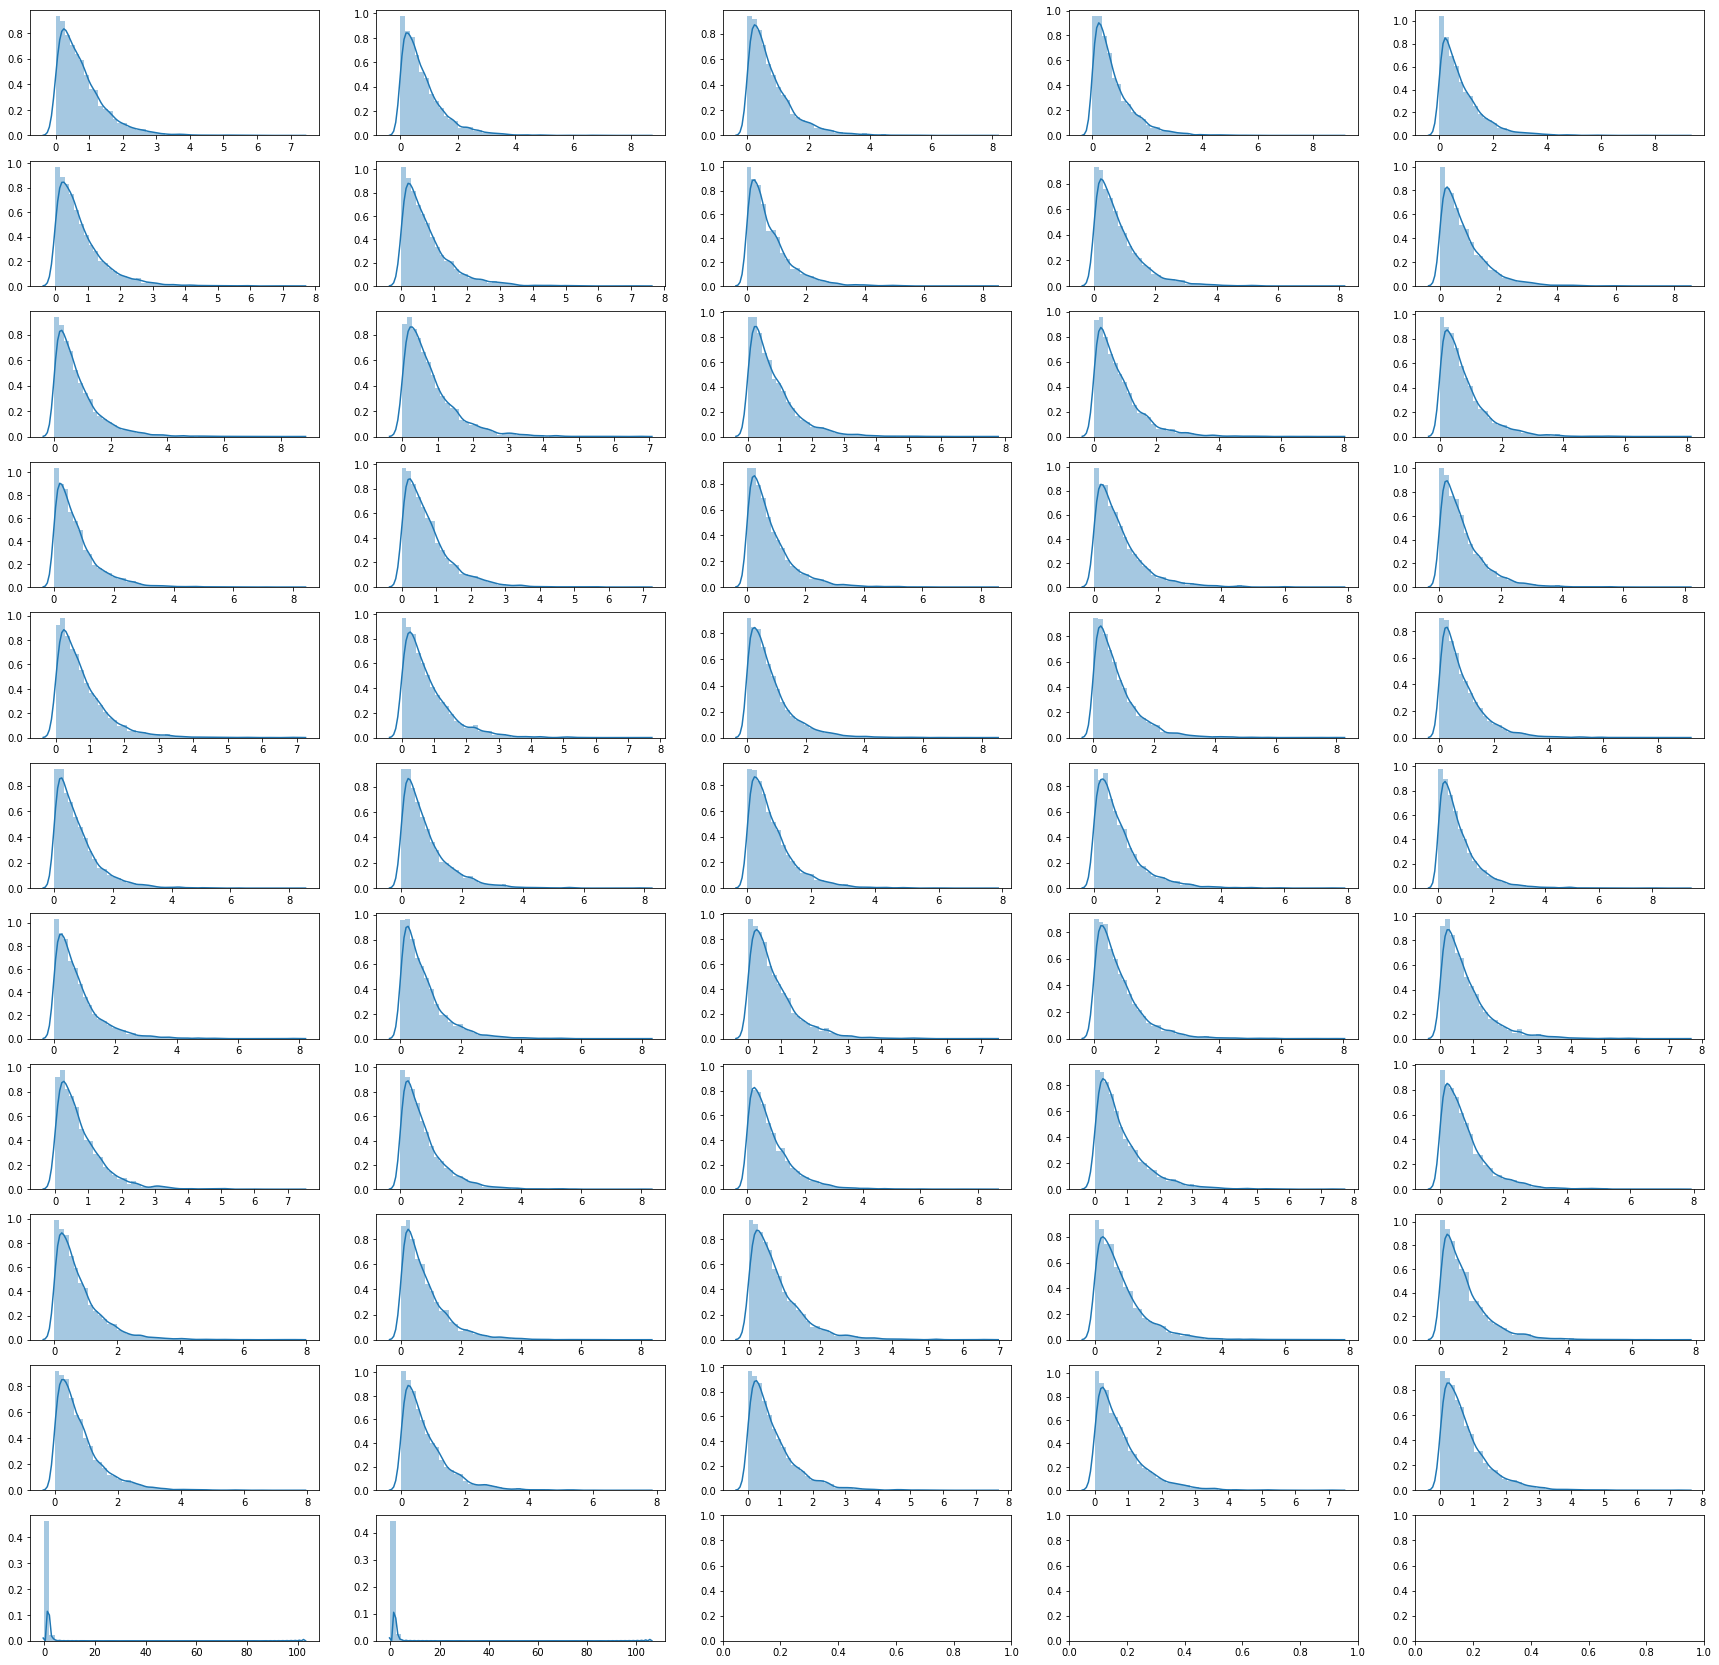

八方向


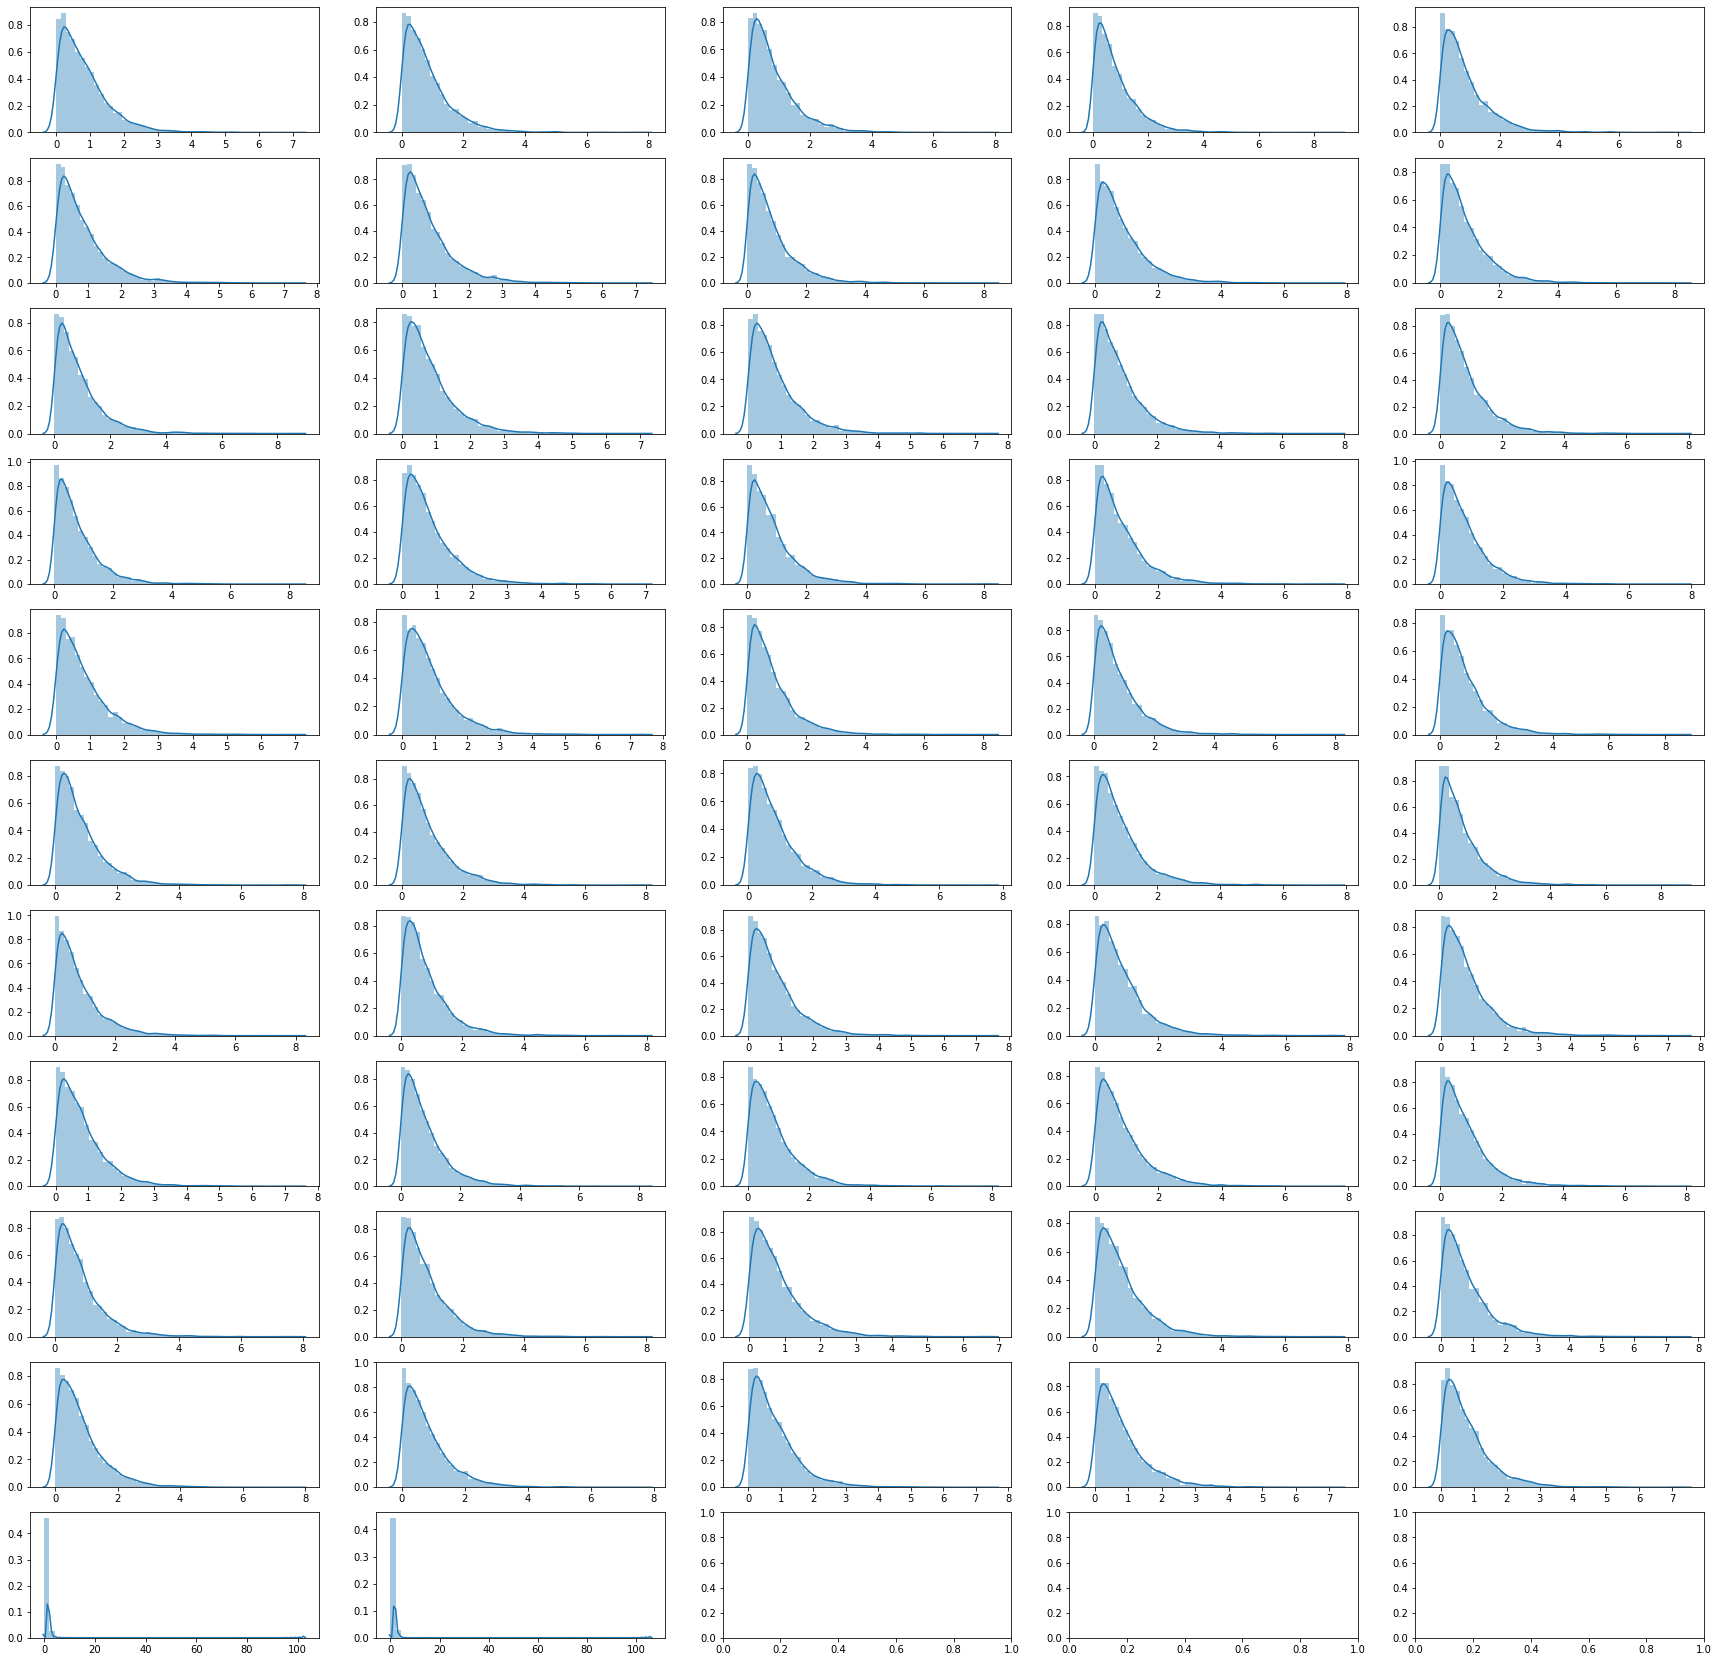

In [40]:
print('四方向')
plot_new(nonzero_resi_1)

print('八方向')
plot_new(nonzero_resi_2)

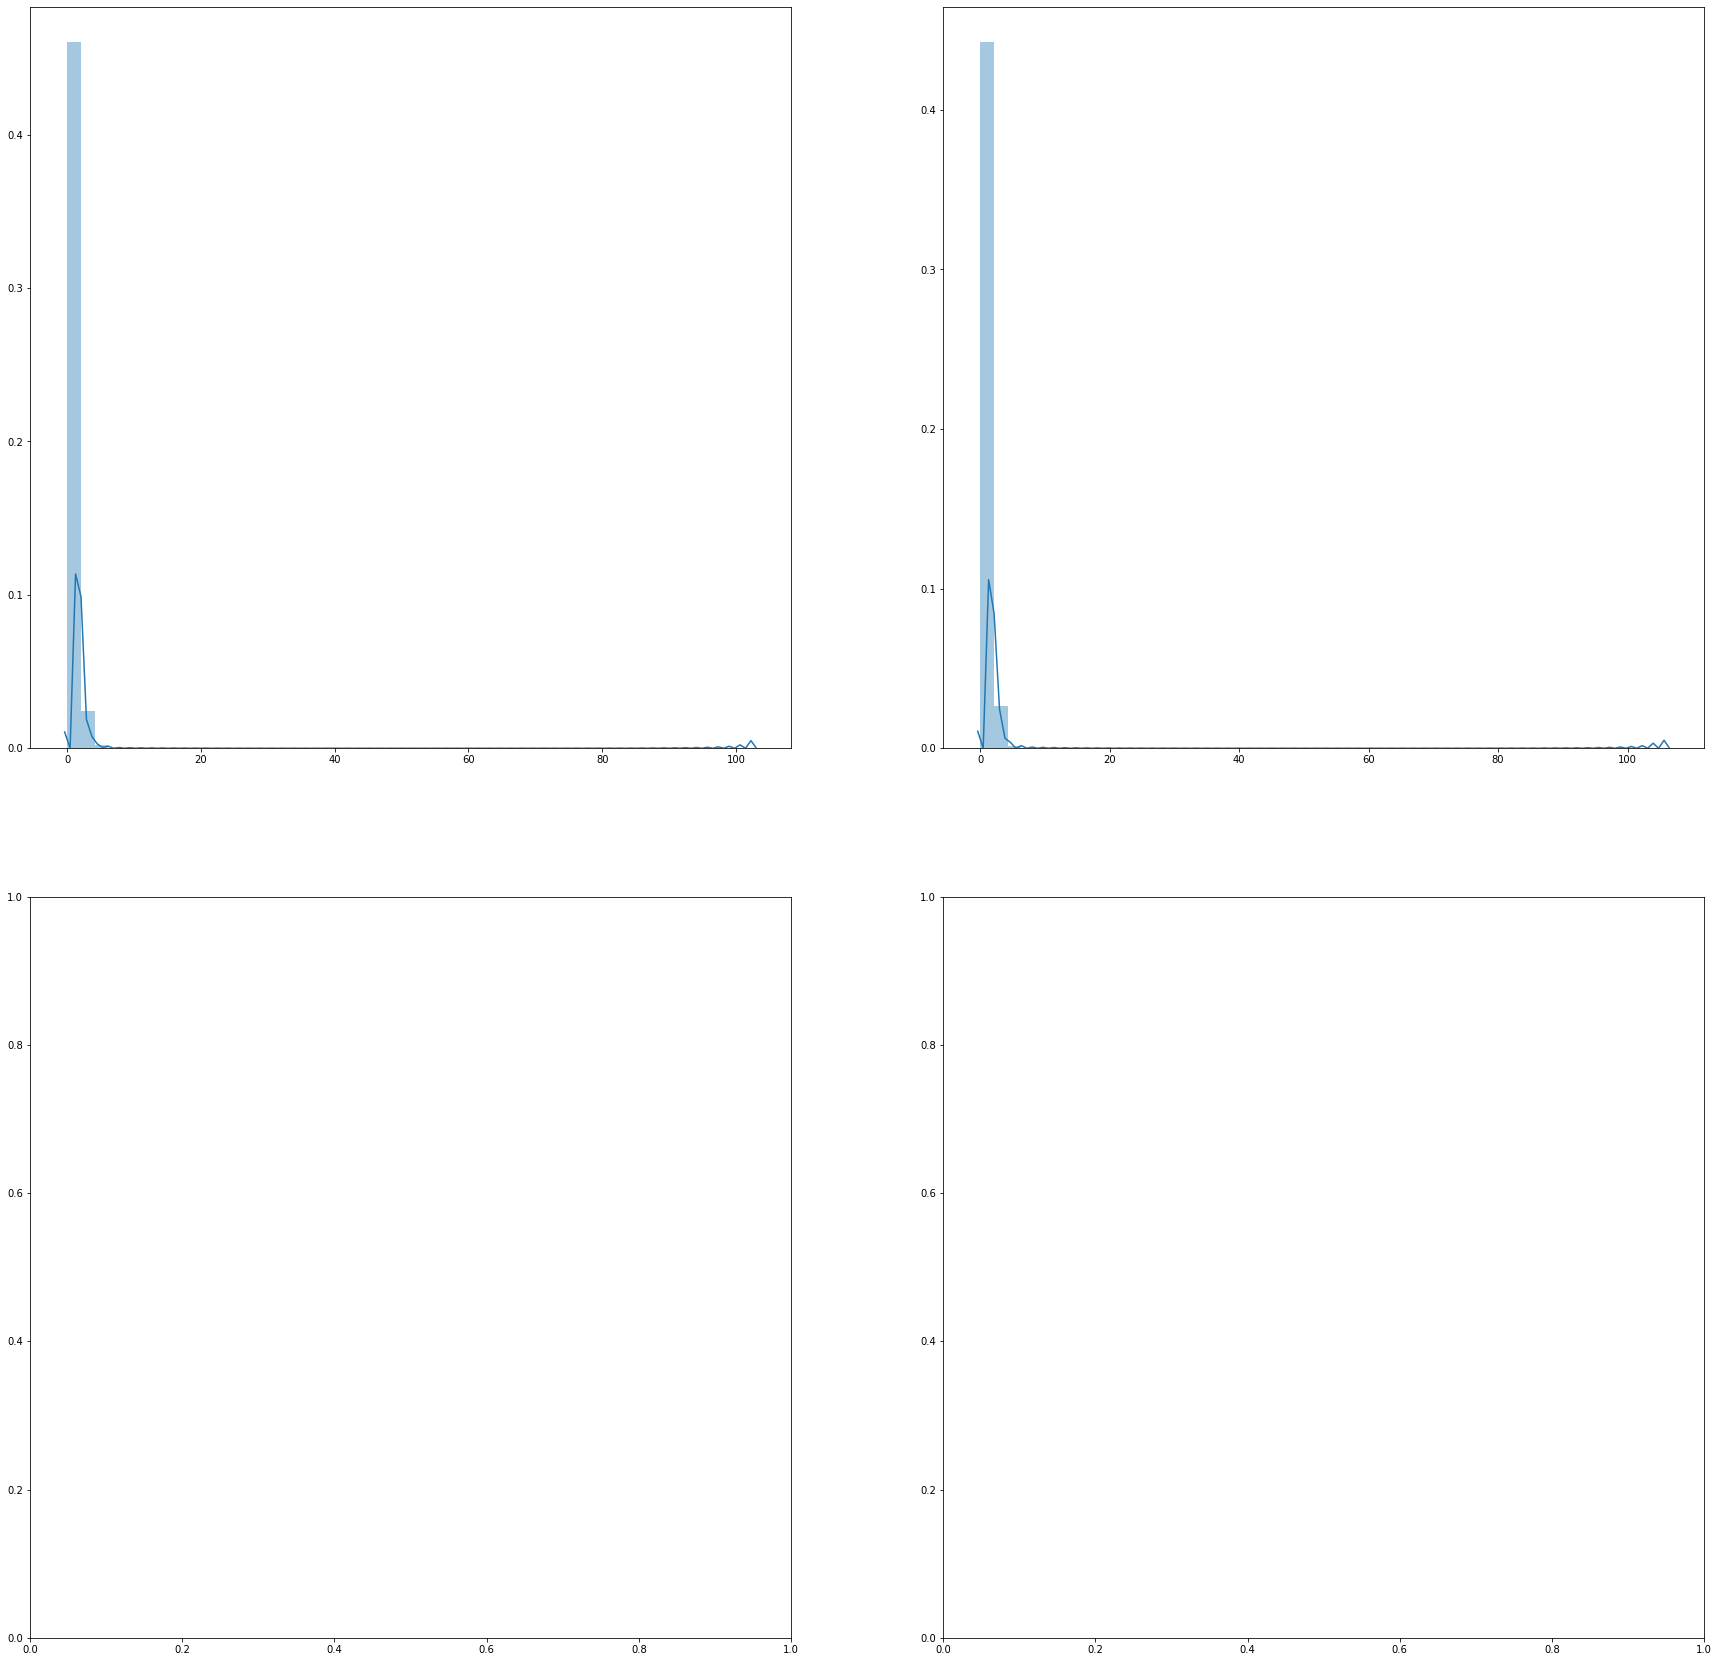

In [44]:
y = 2
x = 2
fig,ax = plt.subplots(y,x,figsize=(30,30))
count = 50
for i in range(y):
    for j in range(x):
        if count >= 52:
            break
        dummy = sns.distplot(nonzero_resi_1[count], ax=ax[i, j])
        count += 1
    if count >= 52:
        break

plt.show()

## 50, 51番目の経年劣化

- 明らかに異常な値が存在する

     -> この値は0から変化した測定値と考えられる
     
--------------------------------------

## 実験

1. 散布図で確認

2. 正規性の確認

3. ホテリング理論適用

In [35]:
resi_sum_1, resi_mean_1 = summean_residual(nonzero_resi_1)
resi_sum_2, resi_mean_2 = summean_residual(nonzero_resi_2)

# 1.散布図

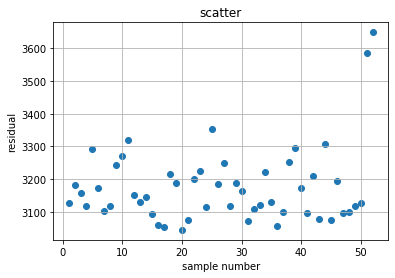

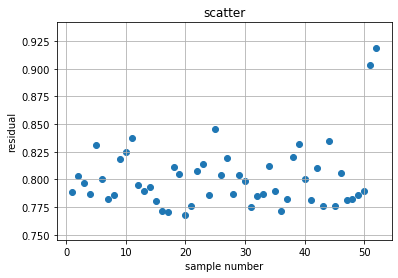

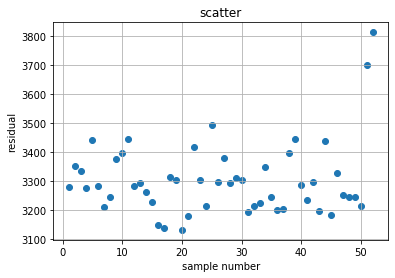

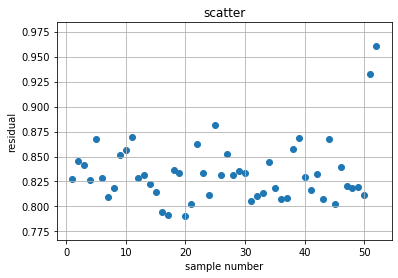

In [36]:
ten(resi_sum_1)
ten(resi_mean_1)
ten(resi_sum_2)
ten(resi_mean_2)

# 2.正規性の確認

QQプロット


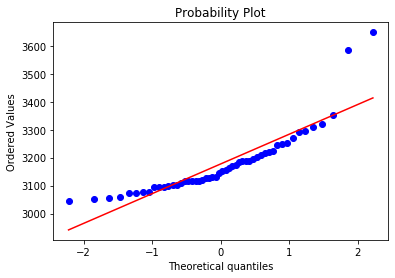

コルモゴロフスミルノフ検定0.26800463383826695
シャピロウィルク検定5.867346999366418e-07

QQプロット


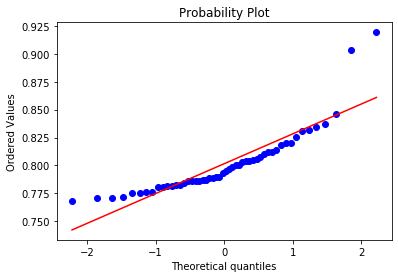

コルモゴロフスミルノフ検定0.26386892909163545
シャピロウィルク検定6.829647531958472e-07

QQプロット


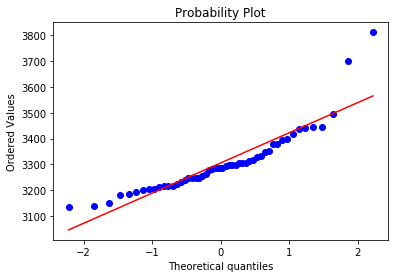

コルモゴロフスミルノフ検定0.1351965158997712
シャピロウィルク検定8.213729415729176e-06

QQプロット


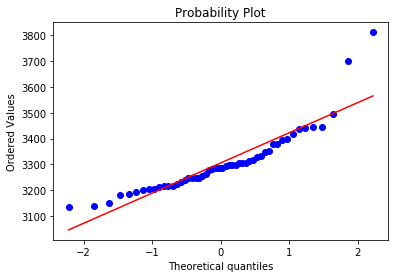

コルモゴロフスミルノフ検定0.13875471863042202
シャピロウィルク検定9.984277312469203e-06



In [37]:
print('QQプロット')
qq(resi_sum_1)
a = kolmogorov_smirnov(resi_sum_1)
b = shapiro_wilk(resi_sum_1)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

print('QQプロット')
qq(resi_mean_1)
a = kolmogorov_smirnov(resi_mean_1)
b = shapiro_wilk(resi_mean_1)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

print('QQプロット')
qq(resi_sum_2)
a = kolmogorov_smirnov(resi_sum_2)
b = shapiro_wilk(resi_sum_2)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

print('QQプロット')
qq(resi_sum_2)
a = kolmogorov_smirnov(resi_mean_2)
b = shapiro_wilk(resi_mean_2)

print(f'コルモゴロフスミルノフ検定{a}')
print(f'シャピロウィルク検定{b}')
print()

## 結果

- コルモゴロフスミルノフ検定は棄却されていない．

- QQプロットをみる限り正規性はないと考えられる．

------------------------------------

## 正規性はなさそうだが，KS検定では棄却されていないので，ホテリング理論を適用してみる．

- グラフの赤線がカイ二乗分布による5%水準の闘値（有意水準）

- 赤線より上を異常値と判定する．

# 3.ホテリング理論適用

ホテリング理論結果


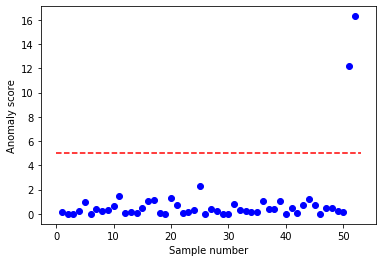

散布図


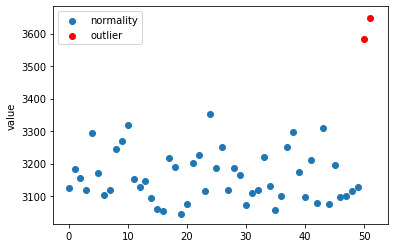

異常index：51
異常index：52

ホテリング理論結果


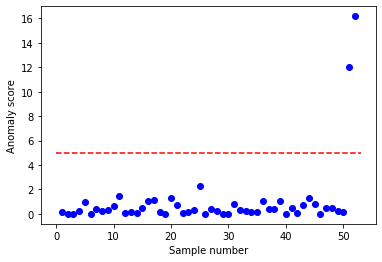

散布図


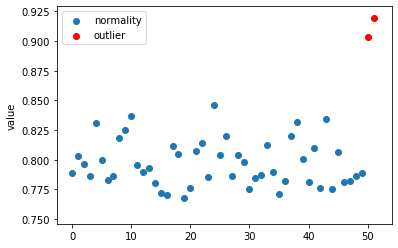

異常index：51
異常index：52

ホテリング理論結果


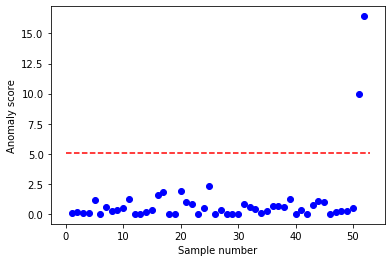

散布図


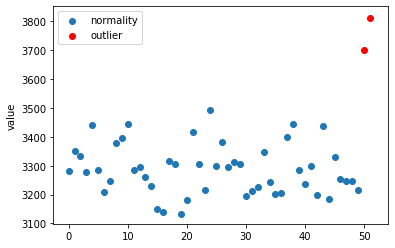

異常index：51
異常index：52

ホテリング理論結果


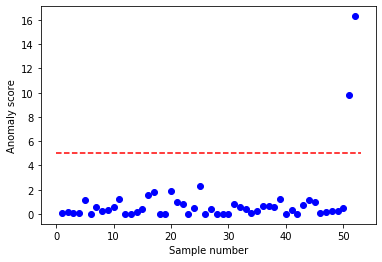

散布図


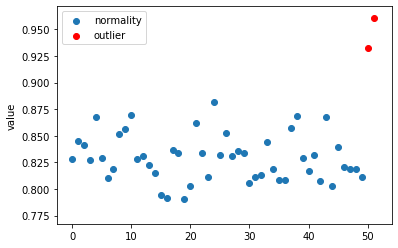

異常index：51
異常index：52



In [54]:
hoteling(resi_sum_1)
hoteling(resi_mean_1)
hoteling(resi_sum_2)
hoteling(resi_mean_2)

## 結果

- 異常な値として経年劣化させた50,51番目の値を判定できた．